In [159]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
from emcee import EnsembleSampler
from emcee.moves import DEMove, DESnookerMove
import corner

In [160]:
def my_chi2(data, obs, obs_err):
    return np.sum(((data - obs)**2)/obs_err**2)/403
    
def train_PCA_GPE(training_data, theta, primary_components = 2): 
    ss = StandardScaler()
    training_data_scaled = ss.fit_transform(training_data)    
    pca = PCA(n_components = primary_components, whiten = True)
    training_data_PCAd = pca.fit_transform(training_data_scaled)
    gpes = []
    
    for z in training_data_PCAd.T[:primary_components]: # optimize hyper parameters for each pc
        kernel = RBF(length_scale = 1 * np.ones(theta.shape[1]), 
                         length_scale_bounds = (1e-10, 1e10)) + WhiteKernel(noise_level_bounds=(1e-10, 1e1))
        gpe = GaussianProcessRegressor(kernel = kernel,  n_restarts_optimizer = 5) #, normalize_y = True)
        gpes.append(gpe.fit(theta, z))
    
    return gpes, pca, ss

def invert_cov(cov, var_trans, nsamples, nkp):
    return np.dot(np.array(cov).T, var_trans).reshape(nsamples, nkp, nkp) # A.T * cov * A ?

def return_predictions(emulators, theta, return_std_ = True): # fix for return_std = False
    gpes = emulators[0]
    pca = emulators[1]
    ss = emulators[2]
    nsamples = len(theta)
    npc = len(gpes) # number of principal components
    nkp = np.shape(ss.scale_)[0] # number of kinematical points
                   
    mean_prediction = []
    cov_prediction = []
    
    for gpe in gpes: # predicts per principal component: len(gpes) = npc 
        
        mean, cov = gpe.predict(theta, return_cov = return_std_)
        gp_var2 = cov.diagonal()[:, np.newaxis]
        
        mean_prediction.append(mean)
        cov_prediction.append(gp_var2)

    # inverse transform mean prediction
    pred_r = ss.inverse_transform(pca.inverse_transform(np.array(mean_prediction).T))
    
    # make transformation matrix for error
    trans_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) # transformation matrix
    A = trans_matrix[:npc] 
    var_trans = np.einsum('ki,kj->kij', A, A, optimize = False).reshape(npc, nkp**2)
    
    # inverse transform diagonal covariance matrix
    cov_rpca = invert_cov(cov_prediction, var_trans, nsamples, nkp)
    std_preds = np.sqrt(np.diagonal(cov_rpca, axis1 = 1, axis2 = 2)) # standard devs are just
    err_r = ss.scale_ * std_preds
    
    return pred_r, err_r

# log formulas

# log likelihood
def log_likelihood(theta, emulators, data, data_err): # one set of theta only
    theta_reshaped = theta.reshape(1,-1)
    predict, predict_err = return_predictions(emulators, theta_reshaped, return_std_ = True)    
    err2 = (predict_err**2 + (data_err)**2) 
    ll = np.log(2*np.pi*err2) + ((data - predict)**2) / err2 #np.log is natural log 
    return -.5*np.sum(ll)

# some flat prior that sets the bounds of the parameters
def log_flat_prior(theta, l_bounds, u_bounds):
    
    for i in range(np.size(theta)): # check if each parameter is within bounds
        if theta[i] < l_bounds[i] or theta[i] > u_bounds[i]:
            return -np.inf
       
    return 0

# posterior
def log_posterior(theta, l_bounds, u_bounds, emulators, data, data_err):
    return log_likelihood(theta, emulators, data, data_err) + log_flat_prior(theta, l_bounds, u_bounds)

# emcee sampler function
def emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, data, data_err, moves = None):
    sampler = EnsembleSampler(n_walkers, 
                              n_params, 
                              log_posterior,
                              moves = moves,
                              #moves = [(DEMove(), 0.8), (DESnookerMove(), 0.2)], 
                              args = [l_bounds, u_bounds, emulators, data, data_err], 
                              threads = 4) # default is stretchmove
    return sampler

def return_samples(p0, l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler):
    burn = sampler.run_mcmc(p0, n_burn, progress = True) # initially train until samples converge
    sampler.reset() # remove burn samples
    run = sampler.run_mcmc(burn, n_samples, progress = True)
    return sampler.get_chain(flat = True)

In [161]:
def plot_model_vs_exp(q2s, ss, model_values, exp_df):
    colors  = ['orange', 'purple', 'yellow', 'pink', 'red','cyan', 'maroon', 'teal', 'green']
    for j in range(len(q2s)):
        q2 = q2s[j]
        Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
        Q2_indeces = exp_df.index[Q2_region].tolist()
        exp_df_region = exp_df[Q2_region]
        dat = np.array(exp_df_region['sigma_r'])
        dat_err = np.array(exp_df_region['error'])
        xb = np.array(exp_df_region['xbj'])
 
        for i in range(len(model_values)):
            model = [ model_values[i,qq2] for qq2 in Q2_indeces]
            if i == 0:
                plt.plot(xb, model, alpha = 0.8, linewidth = 1.0, color = colors[j], label = "${}$".format((q2)))
            else:
                plt.plot(xb, model, alpha = 0.5, linewidth = 0.3, color = colors[j])
                
        if j == 0:
            plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.', label = "Data")        
        else:
            plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.')


    plt.xlabel("$x_{bj}$", fontsize = 18)
    plt.ylabel("$\sigma_r$ (mb)", fontsize = 18)
    # set y and x label font sizes
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xscale('log')
    plt.xlim = (10e-6, 10e-1) 
    plt.ylim = (0.4, 1.6)
    plt.title("5-parameter fit", fontsize = 20)
    #plt.yscale('log')
    # place legend outside of plot
    plt.legend(title = "$Q^2$ (GeV$^2$)", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.legend(title = "$Q^2$ (GeV$^2$)")
    return plt.show()


In [162]:
def plot_exp_vs_map_vs_median(q2s, ss, map_values, exp_df, median_values):
    
    colors  = ['orange', 'purple', 'brown', 'pink', 'maroon', 'olive', 'cyan', 'magenta', 'teal', 'green']
    for j in range(len(q2s)):
        q2 = q2s[j]
        Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
        Q2_indeces = exp_df.index[Q2_region].tolist()
        exp_df_region = exp_df[Q2_region]
        dat = np.array(exp_df_region['sigma_r'])
        dat_err = np.array(exp_df_region['error'])
        xb = np.array(exp_df_region['xbj'])

        for i in range(len(map_values)):
            model = [map_values[i,qq2] for qq2 in Q2_indeces]
            plt.plot(xb, model, '--', alpha = 0.9, color = colors[j], label = "MAP estimates")

        for i in range(len(median_values)):
            model = [median_values[i,qq2] for qq2 in Q2_indeces]
            plt.plot(xb, model, alpha = 0.5, color = colors[j], label = " Posterior median")

    # for i in range(len(median_values_low)):
    #     modellow = [median_values_low[i,qq2] for qq2 in Q2_indeces]
    #     modelhigh = [median_values_high[i,qq2] for qq2 in Q2_indeces]
    #     plt.fill_between(xb, modellow, modelhigh, alpha = 0.4, label = "{} credible region".format(confidence))
    
        plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.', label = "HERA Data")
    
    #plt.title(r"$Q^2 = {} $".format((q2)) + r" GeV$^2$; $\sqrt{s}$" + " = {} GeV".format(ss))   
    plt.xlabel("$x_{bj}$")
    plt.ylabel("$\sigma_r$ (mb)")
    plt.xscale('log') 
    #plt.legend()
    return plt.show()


In [163]:
def plot_model_vs_exp_wtrain(q2, ss, model_values, exp_df):
    splots = 2
    fig, ax = plt.subplots(1,splots, figsize = (16, 6))

    Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
    Q2_indeces = exp_df.index[Q2_region].tolist()
    exp_df_region = exp_df[Q2_region]
    dat = np.array(exp_df_region['sigma_r'])
    dat_err = np.array(exp_df_region['error'])
    xb = np.array(exp_df_region['xbj'])
    

    for i in range(len(model_values)):
        model = [model_values[i,qq2] for qq2 in Q2_indeces]
        ax[0].plot(xb, model, alpha = 0.3, color = 'orange',linewidth = 0.5)
        if i == len(model_values)-1:
            ax[0].plot(xb, model, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "Emulator (Posterior Samples)") 
    
    ax[0].plot(np.average(model))
        
    for i in range(len(training_set_all)):
        train = [training_set_all[i,qq2] for qq2 in Q2_indeces]
        ax[1].plot(xb, train, alpha = 0.3, color = 'orange', linewidth = 0.5)
        if i == len(pred_r)-1:
            ax[1].plot(xb, train, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "Training Data")

    for i in range(splots):
        ax[i].errorbar(xb, dat, yerr = dat_err, color = '#0343DF',  fmt = '.', alpha = 0.7, label = "HERA Data")
        ax[i].set_title("$Q^2$ = {} GeV$^{}$; ".format(q2, 2) + "$\sqrt{s}$ = " + str(ss) + " GeV")
        ax[i].set_xlabel("$x_{bj}$")
        ax[i].set_ylabel("$\sigma_r$ (mb)")
        #ax[0].set_ylim(0.5, 2.0)
        ax[i].set_xscale('log') 
        #ax[i].set_yscale('log')
        ax[i].legend()
        
    return plt.show()
 # make cuts
 # check chi2

In [164]:
#fig_label = "4p100d232k"

#folder = "mv5/orthLHS/121d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
folder = "run2/mv5/plainLHS/500d"
#folder = "postsamples/mv5"
train_file, theta_file = [folder + "/train.dat", folder + "/theta.dat"]

#folder2 = "mv5/plainLHS/500d"
folder2 = "postsamples/mv5"
train_file2, theta_file2 = [folder2 + "/train.dat", folder2 + "/theta.dat"]

# range of theta
l_bounds = [.001, 0.5, 0.5, 0.1, 5.0] # Qs02 , ec, C2, sigma0/2, gamma
u_bounds = [0.2, 2.0, 40.0, 40.0, 30.0]
#l_bounds_in = [0.025, 0.85, 4.3, 3.8, 12.0] # range of peak from initial run
#u_bounds_in =  [0.125, 1.35, 37.0, 32.0, 24.0]

exp_file = "exp_all.dat"
param_names = ["$Q_{s0}^{2}$ (GeV²)",
               "$\gamma$",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ (mb)"] # ordered
n_params = len(param_names)

# cut training data ()
exp_df = pd.DataFrame(np.loadtxt(exp_file), columns = ['xbj', 'Qs2', 'sqrt(s)', 'sigma_r', 'error'])
a, b = 2.0, 50.0 
# Q2_region = exp_df['Qs2'] < 10.0 # boolean
Q2_region = (exp_df['Qs2'] >= a) & (exp_df['Qs2'] <= b)
Q2_index = exp_df.index[Q2_region].tolist()
exp_df = exp_df[Q2_region]
xbj = np.array(exp_df['xbj'])
exp = np.array(exp_df['sigma_r'])
exp_err = np.array(exp_df['error'])

In [165]:
train_dataset = pd.DataFrame(np.loadtxt(train_file))
train_dataset2 = pd.DataFrame(np.loadtxt(train_file2))
#train_dataset3 = pd.DataFrame(np.loadtxt(train_file3))
#train_dataset = pd.concat([train_dataset, train_dataset2], ignore_index=True)
train_dataset = train_dataset.iloc[:, Q2_index].T.reset_index(drop=True).T
training_set_all = train_dataset.iloc[:,np.array(train_dataset.columns)].values
params_1 = np.vstack(np.loadtxt(theta_file, unpack = True)).T
params_2 = np.vstack(np.loadtxt(theta_file2, unpack = True)).T
#params_3 = np.vstack(np.loadtxt(theta_file3, unpack = True)).T
#params_all = np.vstack([params_1, params_2])
params_all = np.vstack(np.loadtxt(theta_file, unpack = True)).T

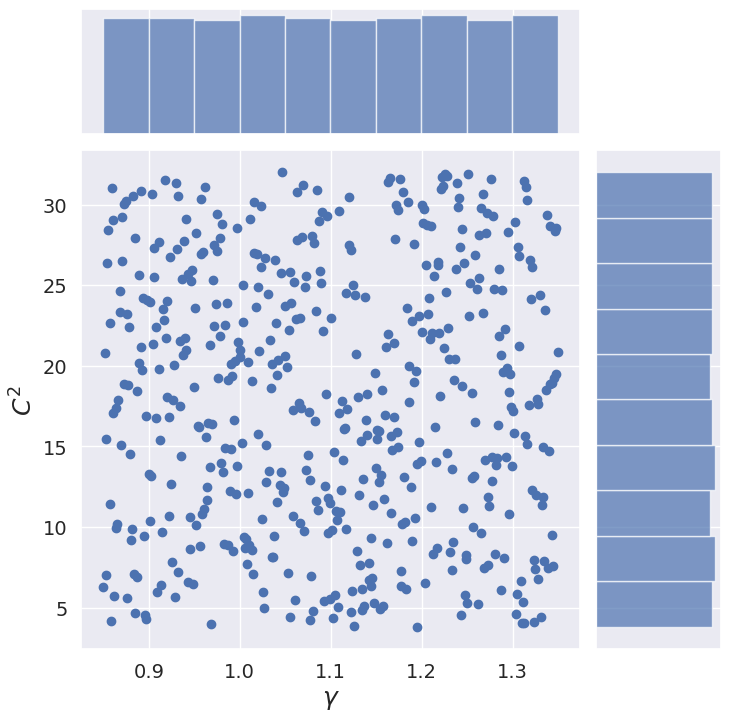

In [166]:
def scatter_hist(a, b, ax, ax_histx, ax_histy):
    # no labels
    x = params_all[:,a]
    y = params_all[:,b]
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    ax.set_xlabel(param_names[a], fontsize = 18)
    ax.set_ylabel(param_names[b], fontsize = 18)
    # set fontsize of tick labels
    ax.tick_params(axis='both', which='major', labelsize=14)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    ax_histx.hist(x, bins=10, alpha=0.7)
    ax_histy.hist(y, bins=10, orientation='horizontal', alpha=0.7)
    #remove y tick labels from histx and histy
    ax_histx.set_yticks([])
    ax_histy.set_xticks([])

# Start with a square Figure.
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(1, 3, ax, ax_histx, ax_histy)
#plt.ylabel(r"$\gamma$")

In [167]:
# space for validating() the gpe emulator
# z = np.zeros(10)
# rd = np.zeros(10)
# ems = []
# prims = []
# for i in range(10):
#     prim = i + 2
#     prims.append(prim)
#     emulators0 = train_PCA_GPE(training_set_all, params_all, primary_components = prim)
#     ems.append(emulators0)
#     pred_rs, err_rs = return_predictions(ems[i], params_all, return_std_ = True)
#     rd_mean = []
#     z_mean = []
#     for f in range(np.shape(pred_rs)[1]):
#         zs = np.mean(np.abs(pred_rs[:,f] - training_set_all[:,f])/err_rs[:,f])
#         rds = np.mean(np.abs(pred_rs[:,f] - training_set_all[:,f]))
#         z_mean.append(zs)
#         rd_mean.append(rds)
#     z[i] = np.mean(z_mean)
#     rd[i] = np.mean(rd_mean)
#     print("current # of primary components", i)

# npc = np.where( z == np.amin(z, axis = 0))[0][0] + 2
# fig = plt.plot(prims, z, 'b.')
# plt.xlabel("Number of Principal Components")
# plt.ylabel("Mean Z score")

In [168]:
# plt.plot(prims, rd, 'r.')
# plt.xlabel("Number of Principal Components")
# plt.ylabel("Mean Relative Difference")

In [169]:
# train pca, scaler, and gpe
npc = 6 # npc 9 best for 1000d points
#emulators = train_PCA_GPE(training_set, myparams, primary_components = npc)
emulators = train_PCA_GPE(training_set_all, params_all, primary_components = npc)
# return predictions of fits
pred_r, err_r = return_predictions(emulators, params_all, return_std_ = True)
#pred_r_train, err_r_train = return_predictions(emulators, myparams, return_std_ = True)

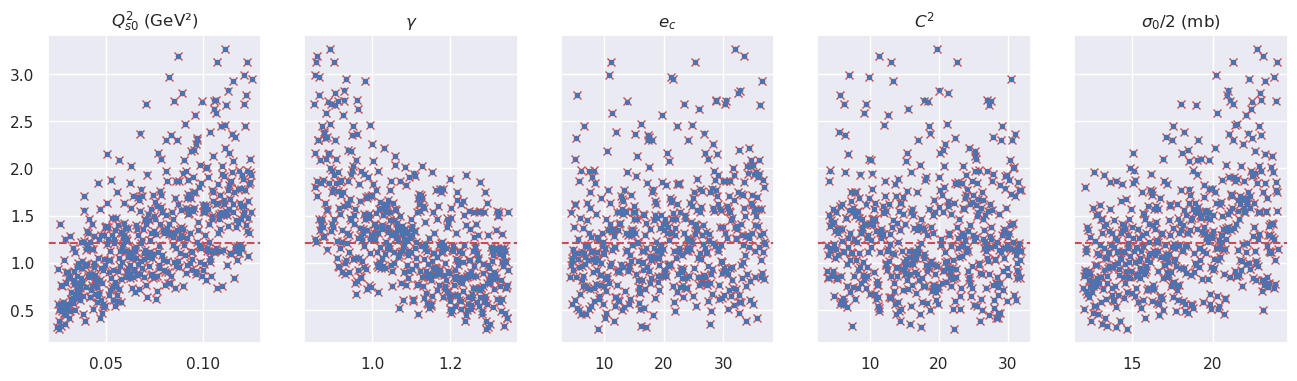

In [170]:
# plot for first kinematical point, comparing training da$Q_{s0}^{2}$ (GeV²)= 0.166
kp = 100
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    #ax[i].errorbar(myparams_test[:,i], pred_r[:,kp], fmt = '.', yerr = err_r[:,kp], label = "GPE Prediction on Test")
    ax[i].errorbar(params_all[:,i], pred_r[:,kp], fmt = '.', yerr = err_r[:,kp], label = "GPE Prediction on Train")
    ax[i].plot(params_all[:,i], training_set_all[:,kp], 'rx', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    #ax[i].legend()
    #ax[i].set_ylim(-2, 8)

Text(0.5, 0, 'Training Data $\\sigma_r$')

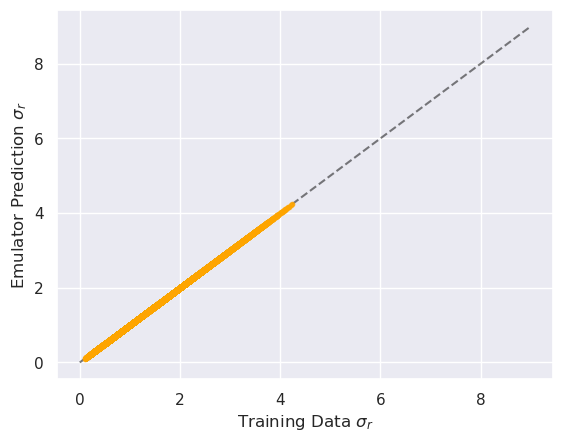

In [171]:
diag = np.linspace(0,9)
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

for i in range(403):
    plt.plot(training_set_all[:,i], pred_r[:,i], '.', color = "orange", alpha = 0.5)

plt.ylabel("Emulator Prediction $\sigma_r$")
plt.xlabel("Training Data $\sigma_r$")
#plt.ylim(0.0, 4.0)
#plt.xlim(0.0, 4.0)

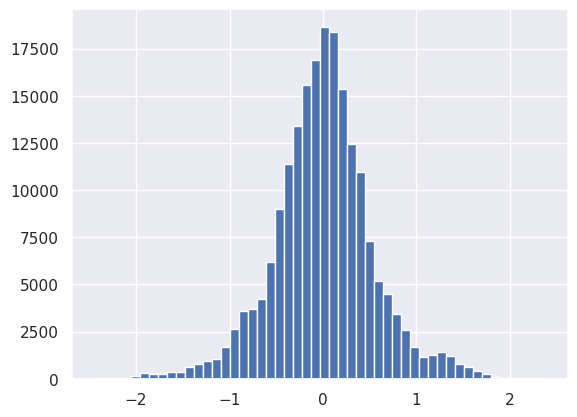

In [172]:
z = np.array([(pred_r[:,kp] - training_set_all[:,kp]) / err_r[:,kp] for kp in range(403)])
plt.hist(z.flatten(), bins = 50);
# set x limit of histogram


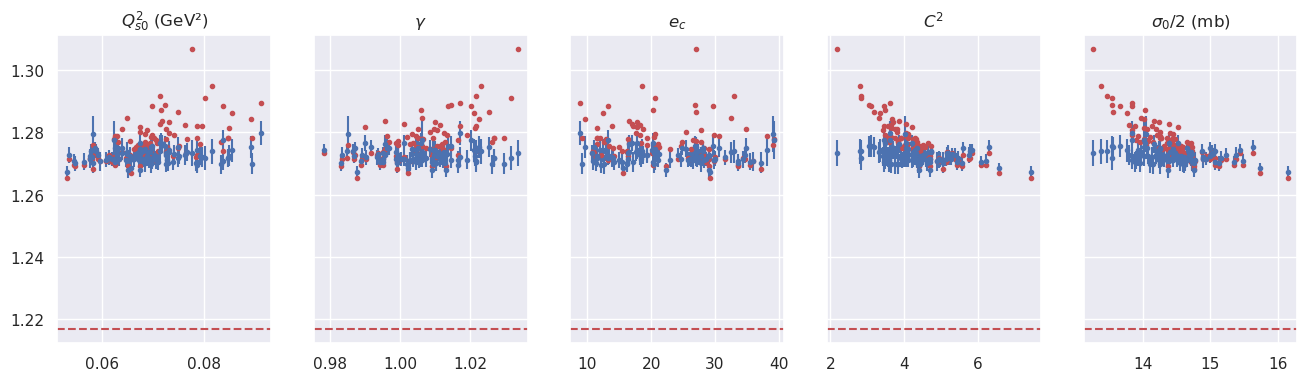

In [183]:
#folder_val = "run2/mv5/plainLHS/100d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
folder_val = "postsamples/mv5v2"
train_file_val, theta_file_val = [folder_val + "/train.dat", folder_val + "/theta.dat"]
train_dataset_val = pd.DataFrame(np.loadtxt(train_file_val))
train_dataset_val = train_dataset_val.iloc[:, Q2_index].T.reset_index(drop=True).T
training_set_val = train_dataset_val.iloc[:,np.array(train_dataset_val.columns)].values
myparams_val = np.vstack(np.loadtxt(theta_file_val, unpack = True)).T
pred_val, err_val = return_predictions(emulators, myparams_val, return_std_ = True)
kp = 290
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].errorbar(myparams_val[:,i], pred_val[:,kp], fmt = '.', yerr = err_val[:,kp], label = "GPE Prediction on Test")
    #ax[i].errorbar(myparams[:,i], pred_r_train[:,kp], fmt = '.', yerr = err_r_train[:,kp], label = "GPE Prediction on Train")
    ax[i].plot(myparams_val[:,i], training_set_val[:,kp], 'r.', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    #ax[i].legend()

Text(0.5, 0, 'z-score')

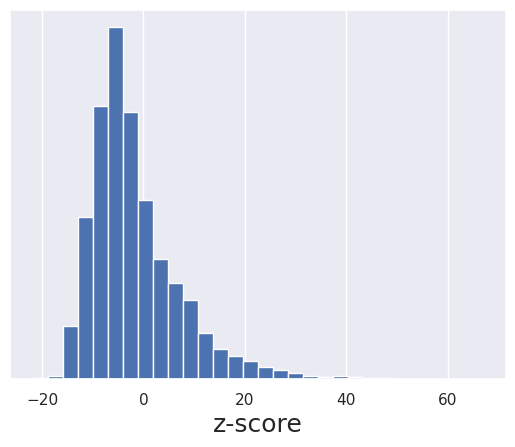

In [115]:
z_val = np.array([(pred_val[:,kp] - training_set_val[:,kp]) / err_val[:,kp] for kp in range(403)])
plt.hist(z_val.flatten(), bins = 30);
#plt.xlim(-2.5,2.5)
# remove x ticks label
plt.yticks([], fontsize = 14)
plt.xlabel("z-score", fontsize = 18)

Text(0, 0.5, 'Training Data $\\sigma_r$')

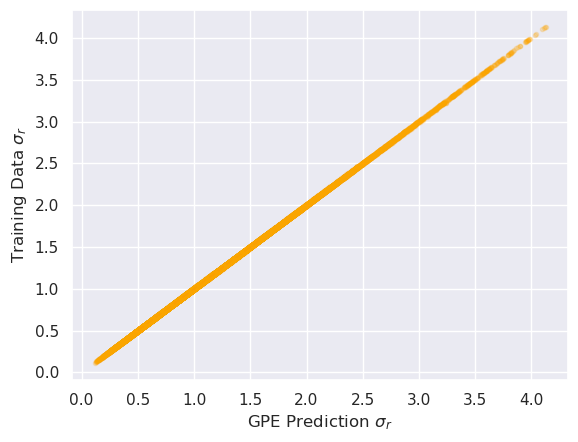

In [55]:
diag = np.linspace(0.5, 1.6)
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

for i in range(403):
    #plt.plot(pred_r[:,i], training_set_test[:,i], '.', color = "orange", alpha = 0.5)
    plt.plot(pred_val[:,i], training_set_val[:,i], '.', color = "orange", alpha = 0.2)

plt.xlabel("GPE Prediction $\sigma_r$")
plt.ylabel("Training Data $\sigma_r$")
#plt.ylim(0.0, 0.5)
#plt.xlim(0.0, 0.5)

In [ ]:
# are there still negative values in the err_r
for i in range(len(exp)):
    for num in err_r[:,i]:
        if num < 0:
            print(num, end=" ")

In [44]:
# getting MAP values

from scipy.optimize import minimize, basinhopping
#posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run 
#l_bounds = [0.001, 0.5, 0.5, 0.1, 5.0] # Qs0² , gamma, ec , C², sigma0/2
#u_bounds = [0.2, 2.0, 40.0, 40.0, 30.0] 
initial_guess = np.array([0.06, 1.0, 18.9, 7.2, 16.36]) # mve from paper

#MAP1 = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), initial_guess)
MAP1 = minimize(lambda theta: -log_likelihood(theta, emulators, exp, exp_err), initial_guess)
print("Initial Guess for minimize: ", initial_guess)
print("log likelihood at initial guess:", -log_likelihood(initial_guess, emulators, exp, exp_err))
print("minimize estimates: ", MAP1.x)
print("log likelihod at minimize", MAP1.fun)

map2_kwargs = {"method": "BFGS"}
#MAP2 = basinhopping(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), initial_guess, niter = 200, minimizer_kwargs = map2_kwargs)
MAP2 = basinhopping(lambda theta: -log_likelihood(theta, emulators, exp, exp_err), initial_guess)
print("basinhopping estimates: ", MAP2.x)
print("log likelihood at basinhopping", MAP2.fun)


Initial Guess for minimize:  [ 0.06  1.   18.9   7.2  16.36]
log likelihood at initial guess: -823.3139621447149
minimize estimates:  [ 0.08933181  1.0225917   8.01398915  4.34185736 14.47600402]
log likelihod at minimize -843.5010323563523
basinhopping estimates:  [ 0.08945567  1.02270616  7.97669013  4.34359603 14.47658391]
log likelihood at basinhopping -843.5010582847406


In [45]:
print("basinhopping estimates: ", MAP2.x)
print("log likelihood at basinhopping", MAP2.fun)

basinhopping estimates:  [ 0.08945567  1.02270616  7.97669013  4.34359603 14.47658391]
log likelihood at basinhopping -843.5010582847406


In [83]:
# initializes the walkers in either a small space around the initial guess
# or in a larger space. Well we'll see how it goes
# initialize
l_bounds = [0.001, 0.50, 0.5, 0.1, 5.0] # Qs0² , gamma, ec , C², sigma0/2
u_bounds = [0.2, 2.0, 40.0, 40.0, 30.0]

# initialized at initial MLE
l_bounds_in = [0.05, 0.9, 18.0, 4.0, 15.0]
u_bounds_in = [0.06, 1.1, 20.0, 5.0, 17.0]

mylimits = np.array([l_bounds, u_bounds])
n_walkers = 100
n_burn = 1000 # 2000
n_samples = 1000

p0 = np.random.uniform(l_bounds_in, u_bounds_in, size = (n_walkers,n_params))
sampler1 = emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, exp, exp_err)
paramsamples = return_samples(p0,l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler1)

for i in range(n_params): # print means
    print(param_names[i] + "= {0:.3f}".format(np.mean(paramsamples[:,i])))

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler1.acceptance_fraction)))

100%|██████████| 1000/1000 [26:02<00:00,  1.56s/it]

$Q_{s0}^{2}$ (GeV²)= 0.070
$\gamma$= 1.006
$e_c$= 21.129
$C^{2}$= 4.320
$\sigma_0/2$ (mb)= 14.456
Mean acceptance fraction: 0.223


In [102]:
# here we find the map values after the sampling with the median values as initial guess
posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run
#initial_guess = [0.06691113,1.00251251,18.0,4.45237291,14.55439918]
#MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), posterior_median)
MAP = basinhopping(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), posterior_median)

percentile_16 = np.percentile(paramsamples, 16, axis = 0)
percentile_84 = np.percentile(paramsamples, 84, axis = 0)
percentile_5 = np.percentile(paramsamples, 5, axis = 0)
percentile_95 = np.percentile(paramsamples, 95, axis = 0)
percentile_50 = np.percentile(paramsamples, 50, axis = 0)

print("MAP estimates: ", MAP.x)
print("log posterior at MAP: ", MAP.fun)
print("Median Values: ", posterior_median)
print("log posterior at Median: ", -log_posterior(posterior_median, l_bounds, u_bounds, emulators, exp, exp_err))
print("16th percentile: ", percentile_16)
print("84th percentile: ", percentile_84)
print("5th percentile: ", percentile_5)
print("95th percentile: ", percentile_95)
print("50th percentile: ", percentile_50)

/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

MAP estimates:  [ 0.08948688  1.02273411  7.96587116  4.34481685 14.47721286]
log posterior at MAP:  -843.501057090941
Median Values:  [ 0.06975315  1.00608852 19.62601668  4.27256925 14.43956602]
log posterior at Median:  -842.8899065251252
16th percentile:  [ 0.06201215  0.99541669 13.12794082  3.49452578 13.92859937]
84th percentile:  [ 0.07866871  1.01674825 30.16137591  5.16086226 14.97835007]
5th percentile:  [ 0.0576559   0.98820101 11.16004714  3.02197273 13.6219134 ]
95th percentile:  [ 0.08394684  1.02354707 35.48328624  5.74037677 15.33516259]
50th percentile:  [ 0.06975315  1.00608852 19.62601668  4.27256925 14.43956602]


/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [86]:
from scipy.signal import find_peaks
from scipy.stats import mode
m = mode(paramsamples[:,2], keepdims=True)
print(m)

ModeResult(mode=array([10.72339977]), count=array([59]))


In [87]:
ec_hist = np.histogram(paramsamples[:,2], bins = 100)
ec_hist[0].argmax()

14

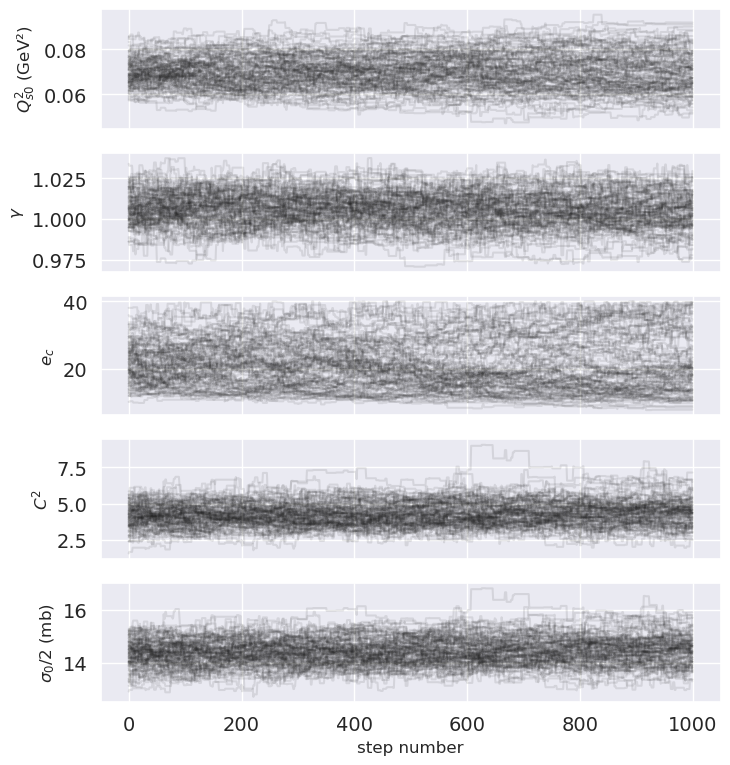

In [88]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.chain[:,:,i].T, color = 'k', alpha = 0.1)
    axes[i].set_ylabel(param_names[i])
    axes[-1].set_xlabel('step number')

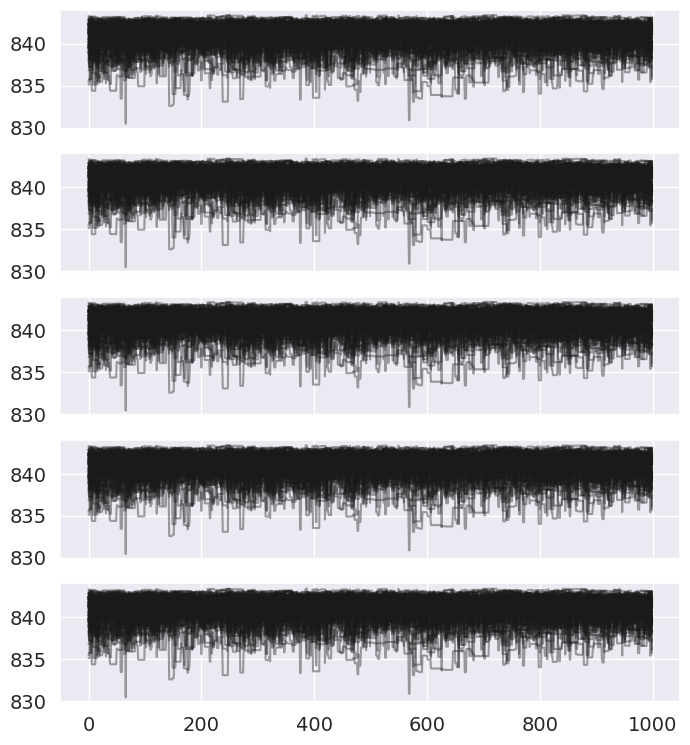

In [89]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.get_log_prob(), color = 'k', alpha = 0.4)
    #axes[i].set_ylim(440, 460)
    #axes[-1].set_xlabel('step number')

In [174]:
# unpack all samples that are saved in txt file
paramsamples = np.vstack(np.loadtxt("mv5/plainLHS/mv5_500d_run2_100w_allsamples.txt", unpack = True)).T

Quantiles:
[(0.0, 0.047148966048107664), (0.5, 0.06975314653311868), (1.0, 0.09539025683658651)]
Quantiles:
[(0.0, 0.9706450533722437), (0.5, 1.0060885234943202), (1.0, 1.0374275816382055)]
Quantiles:
[(0.0, 7.650882710054293), (0.5, 19.626016683298374), (1.0, 39.99994356929673)]
Quantiles:
[(0.0, 1.5796585556261367), (0.5, 4.272569251948687), (1.0, 9.05546308044505)]
Quantiles:
[(0.0, 12.734151487399732), (0.5, 14.439566020687046), (1.0, 16.828122049740838)]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

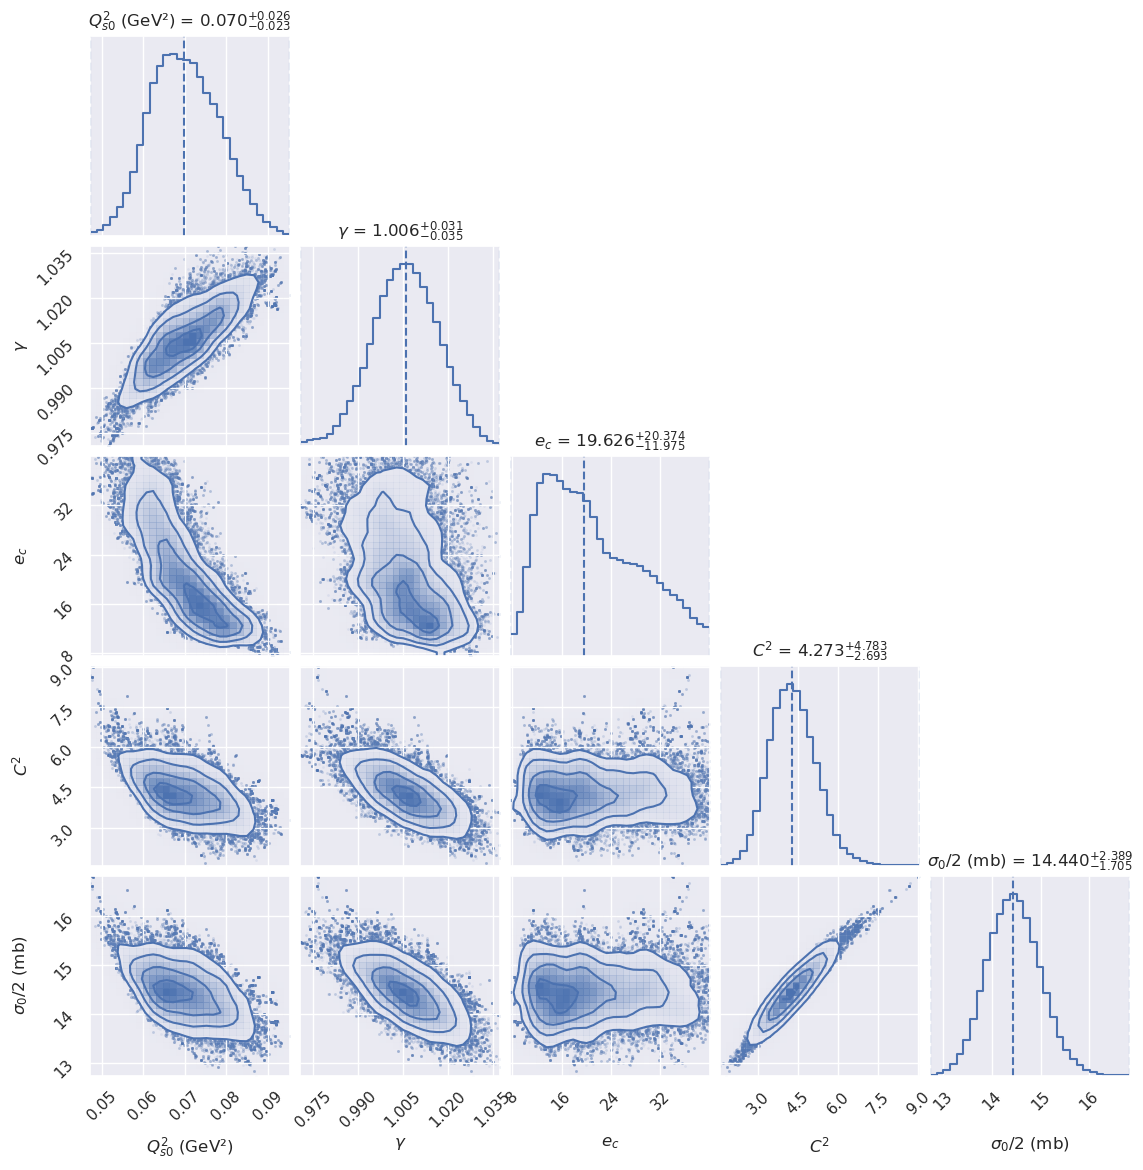

In [184]:
figure = corner.corner(
    paramsamples,
    labels = param_names,
    #plot_contours = True,
    quantiles=[0.00, 0.5, 1.0],
    show_titles = True, # 
    title_fmt = '.3f',
    title_kwargs={"fontsize": 12}, 
    color = 'b',
    bins = 30,
    smooth1d = True,
    smooth = True,
    verbose = True,
    plot_density = True,
    #plot_datapoints = False,
    fillcontours = False, # 
    hist2d_kwargs = {"plot_density": True} # conto
)

ndim = n_params
axes = np.array(figure.axes).reshape((ndim, ndim))
# range0 = [0.025, 0.125]
# range1 = [0.89,1.35]
# range2 = [4.0, 38.0]
# range3 = [2.0, 30.0]
# range4 = [12.0, 24.0]
# ranges = np.array([range0, range1, range2, range3, range4])

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(MAP.x, color="red")
#     ax.set_xlim(ranges[i])

# for yi in range(5):
#     for xi in range(yi):
#         ax = axes[yi, xi]
        #ax.set_xlim(ranges[xi])
        #ax.set_ylim(ranges[yi])


In [104]:
# # run once
inds = np.random.randint(len(paramsamples), size=100)
post_samples = np.array([paramsamples[i] for i in inds])
# np.savetxt("mv5/plainLHS/mv5_500d_run2_100w_sampled_from_posterior_100.txt", np.array(post_samples), delimiter = " ", newline = "\n")
# np.savetxt("mv5/plainLHS/mv5_500d_run2_100w_allsamples.txt", np.array(paramsamples), delimiter = " ", newline = "\n")

In [1]:
# import numpy as np
# i = 0
# lines = ['#!/bin/bash', '\n']
# myparams = np.vstack(np.loadtxt("mv5/plainLHS/mv5_500d_run2_100w_sampled_from_posterior_100.txt", unpack = True)).T
# #print(myparams)
# for qs02, gamma, ec, c2 in myparams[:, 0:4]:
#     line = "sbatch -J bk submitmv5.sh {0} {1} {2} {3} {4}".format(str(qs02), str(gamma) ,str(ec), str(c2),str(i))
#     lines.append(line)
#     i += 1
# np.savetxt('postsamples_mv5_100d_trainedon500d.sh', lines, newline = '\n', fmt='%s')

In [56]:
post_samples = np.vstack(np.loadtxt("mv5/plainLHS/mv5_500d_run2_100w_sampled_from_posterior_100.txt", unpack = True)).T
paramsamples = np.vstack(np.loadtxt("mv5/plainLHS/mv5_500d_run2_100w_allsamples.txt", unpack = True)).T
model_values, model_values_err = return_predictions(emulators, post_samples, return_std_ = True)

In [57]:
from scipy.optimize import minimize
posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), posterior_median)
MAPx = MAP.x
MAPT = MAPx.reshape(1,-1)
MAPT_values, MAPT_values_err = return_predictions(emulators, MAPT, return_std_ = True)
median_values, median_values_err = return_predictions(emulators, np.array(posterior_median).reshape(1,-1), return_std_ = True)
print(MAPx)
print(posterior_median)

/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[ 0.06975315  1.00608852 19.62601668  4.27256925 14.43956602]
[ 0.06975315  1.00608852 19.62601668  4.27256925 14.43956602]


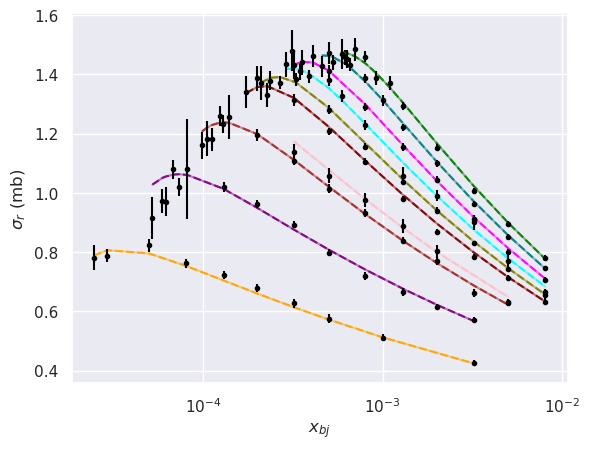

In [58]:
plot_exp_vs_map_vs_median([2., 4.5, 8.5, 10., 15., 18.,  22.,  27.,  35.,  45.], 318.0, MAPT_values, exp_df, median_values)

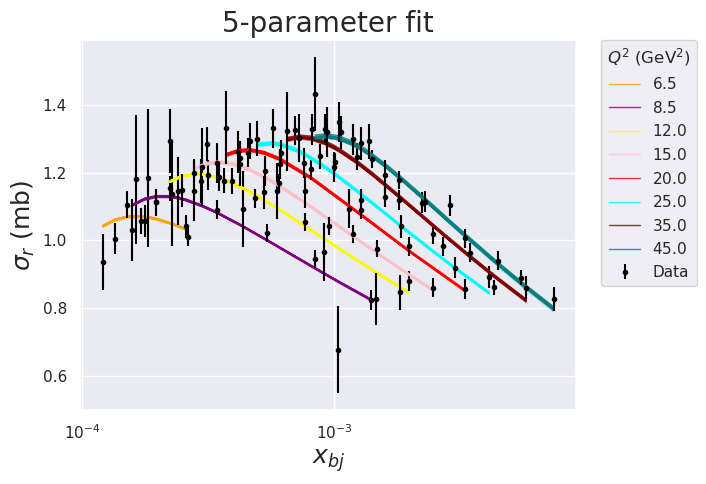

In [59]:
plot_model_vs_exp([6.5, 8.5, 12.0, 15.0, 20.0, 25.0, 35.0, 45.0], 251.0, model_values, exp_df)

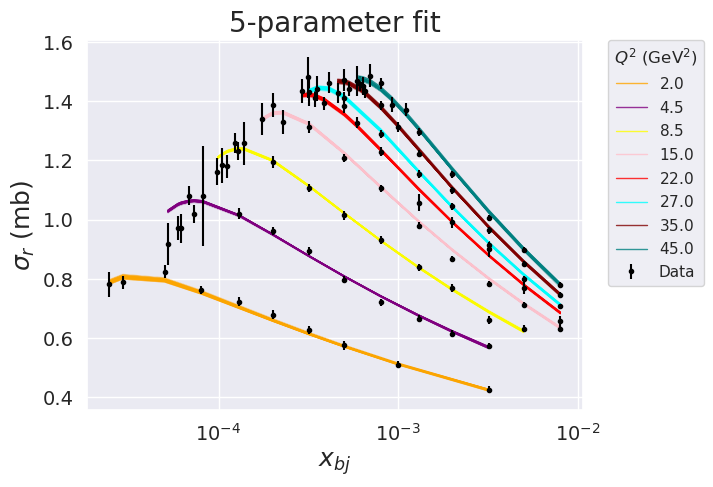

In [60]:
plot_model_vs_exp([2., 4.5, 8.5, 15.0, 22.0,  27.,  35.,  45.], 318.0, model_values, exp_df)

In [61]:
map_x = my_chi2(MAPT_values, exp, exp_err)
median_x = my_chi2(median_values, exp, exp_err)
#chi2(MAPT_values, exp, exp_err)
print('$$\chi^{2}/dof$$ (MAP):' , map_x)
print('$$\chi^{2}/dof$$ (Median):' , median_x)

$$\chi^{2}/dof$$ (MAP): 1.024857112501006
$$\chi^{2}/dof$$ (Median): 1.024857112501006


In [68]:
# VALIDATION TIME
results_postsamples = np.loadtxt("postsamples/mv5v2/train.dat", unpack = True).T
np.shape(results_postsamples)

(100, 403)

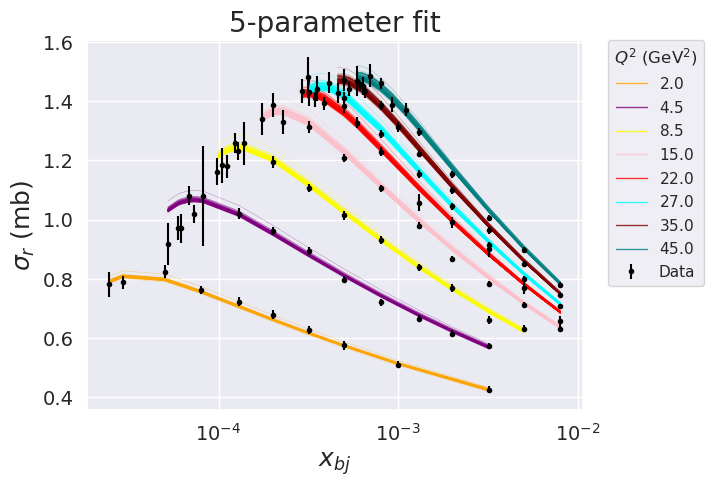

In [69]:
plot_model_vs_exp([2., 4.5, 8.5, 15.0, 22.0,  27.,  35.,  45.], 318.0, results_postsamples, exp_df)

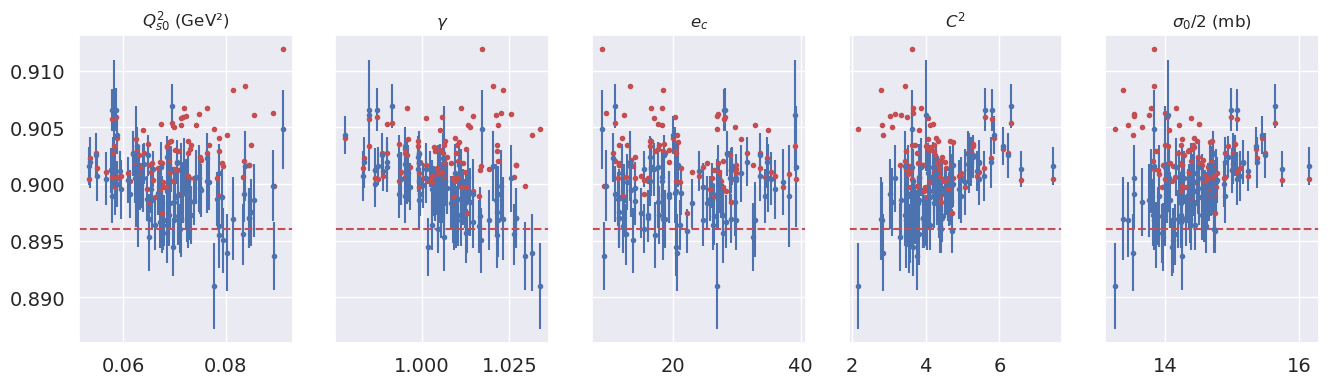

In [79]:
folder_val = "postsamples/mv5v2"
train_file_val, theta_file_val = [folder_val + "/train.dat", folder_val + "/theta.dat"]
train_dataset_val = pd.DataFrame(np.loadtxt(train_file_val))
train_dataset_val = train_dataset_val.iloc[:, Q2_index].T.reset_index(drop=True).T
training_set_val = train_dataset_val.iloc[:,np.array(train_dataset_val.columns)].values
myparams_val = np.vstack(np.loadtxt(theta_file_val, unpack = True)).T
pred_val, err_val = return_predictions(emulators, myparams_val, return_std_ = True)
kp = 161
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].errorbar(myparams_val[:,i], pred_val[:,kp], fmt = '.', yerr = err_val[:,kp], label = "GPE Prediction on Test")
    #ax[i].errorbar(myparams[:,i], pred_r_train[:,kp], fmt = '.', yerr = err_r_train[:,kp], label = "GPE Prediction on Train")
    ax[i].plot(myparams_val[:,i], training_set_val[:,kp], 'r.', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    #ax[i].legend()

Text(0, 0.5, 'Training Data $\\sigma_r$')

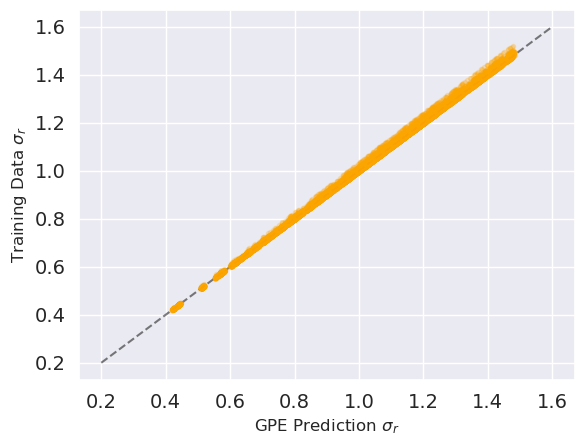

In [74]:
diag = np.linspace(0.2, 1.6)
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

for i in range(403):
    #plt.plot(pred_r[:,i], training_set_test[:,i], '.', color = "orange", alpha = 0.5)
    plt.plot(pred_val[:,i], training_set_val[:,i], '.', color = "orange", alpha = 0.2)

plt.xlabel("GPE Prediction $\sigma_r$")
plt.ylabel("Training Data $\sigma_r$")

Text(0.5, 0, 'z-score')

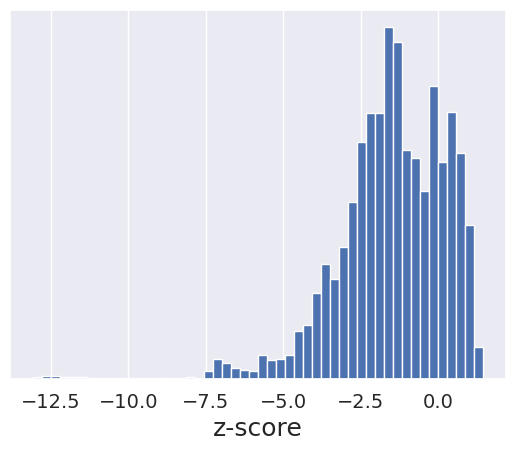

In [75]:
z_val = np.array([(pred_val[:,kp] - training_set_val[:,kp]) / err_val[:,kp] for kp in range(403)])
plt.hist(z_val.flatten(), bins = 50);
#plt.xlim(-2.5,2.5)
# remove x ticks label
plt.yticks([], fontsize = 14)
plt.xlabel("z-score", fontsize = 18)

Text(0, 0.5, 'Model')

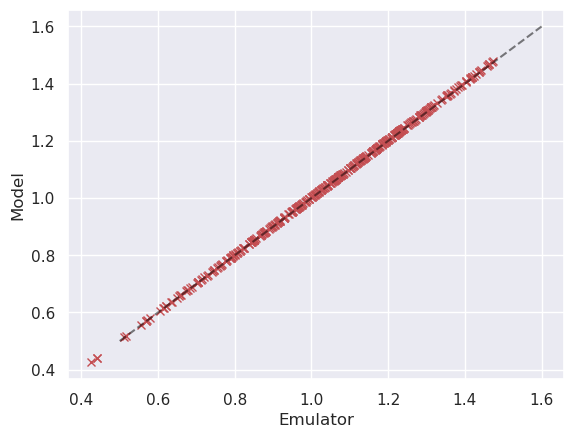

In [205]:
diag = np.linspace(0.5, 1.6)
MAPT_values_model = np.array(np.loadtxt("postsamples/mmm/trains/6.txt"))
median_values_model = np.array(np.loadtxt("postsamples/mmm/trains/5.txt"))
int = np.array(np.loadtxt("postsamples/mmm/trains/0.txt"))
#initial_values, initial_values_err = return_predictions(emulators, int, return_std_ = True)
#plt.plot(exp, MAPT_values.reshape(403), '.', color = 'orange', alpha = 0.5, label = 'MAP');
#plt.plot(exp, MAPT_values_model, '.', color = 'b', label = 'MAP');
#plt.plot(exp, median_values_model, 'x', color = 'r', label = 'median');
#plt.plot(exp, int, '.', color = 'black', alpha = 0.5, label = 'MAP');
#plt.plot(MAPT_values.reshape(403), MAPT_values_model, '.', color = 'b', label = 'MAP')
plt.plot(median_values.reshape(403), median_values_model, 'x', color = 'r', label = 'median')
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)
plt.xlabel("Emulator")
plt.ylabel("Model")

In [206]:
my_chi2(MAPT_values_model, exp, exp_err)

1.0464354732876457

In [ ]:
my_chi2(median_values_model, exp, exp_err)